In [1]:
%load_ext autoreload

In [2]:
%autoreload
import pygmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.physics.elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot
from functools import partial

In [3]:
dt.config()

In [4]:
lc = 0.2
L = 1.
with pygmsh.geo.Geometry() as geom:
    p = geom.add_polygon([[0., 0.], [L, 0.], [L, L], [0., L]], mesh_size=lc)
    # create a default physical group for the boundary lines
    geom.add_physical(p.lines, label="boundary")
    geom.add_physical(p.lines[0], label="down")
    geom.add_physical(p.lines[2], label="up")
    geom.add_physical(p.lines[1], label="right")
    geom.add_physical(p.lines[3], label="left")
    mesh = geom.generate_mesh()

S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_DPD_weights()
S.get_flat_DPP_weights()

ref_node_coords = S.node_coords

In [5]:
down_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "down")
up_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "up")
down_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "down")
up_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "up")
left_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "left")
right_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "right")
left_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "left")
right_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "right")

print(down_bnd_edges_idx)
print(up_bnd_edges_idx)
print(left_bnd_nodes_idx)
print(right_bnd_nodes_idx)

[0, 12, 15, 18, 3]
[7, 34, 37, 40, 9]
[0, 3, 16, 17, 18, 19]
[1, 2, 8, 9, 10, 11]


In [6]:
mu_ = 1.
lambda_ = 10.
gamma_ = 0.2
tau_ = mu_*gamma_
true_curr_node_coords = S.node_coords.copy()
true_curr_node_coords[:, 0] += gamma_*S.node_coords[:, 1]
up_bnd_pos_components = [0]

up_bnd_nodes_pos_x = true_curr_node_coords[up_bnd_nodes_idx, 0]
up_bnd_nodes_pos_y = ref_node_coords[up_bnd_nodes_idx, 1]
down_bnd_pos = ref_node_coords[down_bnd_nodes_idx, :]

In [7]:
# NOTE: without flatten it does not work properly when concatenating multiple bcs;
# fix this so that flatten is not needed (not intuitive)
boundary_values = {"0": (up_bnd_nodes_idx, up_bnd_nodes_pos_x),
                   ":": (down_bnd_nodes_idx, down_bnd_pos)}
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 1000000.
num_faces = S.S[2].shape[0]
embedded_dim = S.space_dim
f = np.zeros((num_faces, (embedded_dim-1)))
#f = np.zeros((S.num_nodes, (embedded_dim-1)), dtype=dt.float_dtype)
#curr_node_coords = jnp.full(
#    S.node_coords.shape, jnp.nan, dtype=dt.float_dtype)
obj = ela.obj_linear_elasticity_energy
#obj = ela.obj_linear_elasticity_primal
x0 = S.node_coords.flatten()
# x0 = true_curr_node_coords.flatten()

#unknown_node_coords = S.node_coords.copy()
#unknown_node_coords[up_bnd_nodes_idx , 0] = np.nan
#unknown_node_coords[down_bnd_nodes_idx, :] = np.nan
#unknown_node_coords_flattened = unknown_node_coords.flatten()
#unknown_node_idx = ~np.isnan(unknown_node_coords_flattened)
#x0 = unknown_node_coords_flattened[unknown_node_idx]
#obj = partial(ela.obj_linear_elasticity_dual,
#                          unknown_node_idx=unknown_node_idx)

# traction bcs
primal_vol_left = S.primal_volumes[1][left_bnd_edges_idx]
primal_vol_right = S.primal_volumes[1][right_bnd_edges_idx]
idx_left_right_edges = left_bnd_edges_idx + right_bnd_edges_idx
bnd_tractions_up = np.zeros(len(up_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_left = -tau_*np.ones(len(left_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_left *= primal_vol_left
#bnd_tractions_left[-1] *= -1
bnd_tractions_right = tau_*np.ones(len(right_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_right *= primal_vol_right
#bnd_tractions_right[-1] *= -1
bnd_tractions_left_right = np.zeros(len(idx_left_right_edges), dtype = dt.float_dtype)
idx_tract_y = up_bnd_edges_idx + idx_left_right_edges
bnd_tractions_y = np.concatenate((bnd_tractions_up, bnd_tractions_left, bnd_tractions_right))
#bnd_tractions_y = np.concatenate((bnd_tractions_left, bnd_tractions_right))

num_edges = S.S[1].shape[0]

ext_forces_coeffs = np.zeros((num_edges, 3), dtype = dt.float_dtype)
ext_forces_coeffs[left_bnd_edges_idx,1] = bnd_tractions_left
ext_forces_coeffs[right_bnd_edges_idx,1] = bnd_tractions_right
#ext_forces_coch_coeffs = np.sum(ext_forces_coeffs*S.primal_edges_vectors, axis=1)
#ext_forces = C.CochainP1(S, ext_forces_coeffs)

boundary_tractions = {'1': (idx_tract_y, bnd_tractions_y),
                     '0': (idx_left_right_edges, bnd_tractions_left_right)}
obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values, 'ext_forces': ext_forces_coeffs}
#obj_args = {'f': f,
#            'boundary_values': boundary_values,
#            'boundary_tractions': boundary_tractions,
#            'curr_node_coords': curr_node_coords}
#obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values, 'boundary_tractions': boundary_tractions}

In [8]:
prb = optctrl.OptimizationProblem(dim=len(x0), state_dim=len(x0),objfun=obj)

prb.set_obj_args(obj_args)
sol = prb.solve(x0=x0, ftol_abs=1e-12, ftol_rel=1e-12, maxeval = 20000)
print(prb.last_opt_result)
curr_node_coords = sol.reshape(S.node_coords.shape)
#print(len(sol))
#curr_node_coords = ela.set_displacement_bc(curr_node_coords, boundary_values)
#curr_node_coords_flattened = curr_node_coords.flatten()
#curr_node_coords_flattened = curr_node_coords_flattened.at[jnp.isnan(
#    curr_node_coords_flattened)].set(sol)
#curr_node_coords = curr_node_coords_flattened.reshape(S.node_coords.shape)

Traced<ShapedArray(float64[109,3])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float64[109,3])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[109,3])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[109,3])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[109,3]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fca3417aa30>, in_tracers=(Traced<ShapedArray(float64[109,3]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float64[109,3]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x7fca2c147510; to 'JaxprTracer' at 0x7fca2c1474c0>], out_avals=[ShapedArray(float64[109,3])], primitive=pjit, params={'jaxpr': { lambda ; a:f64[109,3] b:f64[109,3]. let c:f64[109,3] = mul b a in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'fn', 'keep_unused': False, 'inline': True}, effects=set(), source

In [10]:
#print(obj(sol, f, gamma, boundary_values, boundary_tractions))
#print(obj(true_curr_node_coords.flatten(), f, gamma, boundary_values, boundary_tractions))
true_node_coch = C.CochainP0(S, curr_node_coords)
f_coch = C.CochainP2(S, f)
#res = ela.force_balance_residual_primal(true_node_coch, f_coch, boundary_tractions)
forces = ela.force_balance_residual_primal(true_node_coch, f_coch, boundary_tractions)
print(forces.coeffs[down_bnd_edges_idx,:])
#bad_coeffs =np.where(np.abs(res.coeffs[:,1]) > 1e-8)
#print(bad_coeffs)

[[-3.99999953e-02 -1.43321047e-08]
 [-3.99999952e-02  1.55225022e-08]
 [-3.99999958e-02  1.29804691e-09]
 [-3.99999952e-02 -1.57960726e-08]
 [ 3.99999953e-02 -1.48124549e-08]]


In [17]:
strain = ela.get_infinitesimal_strain(curr_node_coords)
stress = ela.get_stress(strain)

print("strain=", strain)
print("stress=", stress)

strain= [[[-6.07161088e-09  9.99999884e-02]
  [ 9.99999884e-02  9.79318671e-09]]

 [[-8.11064216e-10  9.99999887e-02]
  [ 9.99999887e-02 -2.07052042e-10]]

 [[-2.42606601e-10  9.99999947e-02]
  [ 9.99999947e-02  4.21022417e-09]]

 [[ 7.30774130e-09  9.99999894e-02]
  [ 9.99999894e-02 -1.11933314e-08]]

 [[-8.52983240e-11  9.99999941e-02]
  [ 9.99999941e-02 -3.72755049e-09]]

 [[ 8.75027673e-09  9.99999965e-02]
  [ 9.99999965e-02 -1.15955605e-08]]

 [[-8.51260396e-09  9.99999965e-02]
  [ 9.99999965e-02  1.11255301e-08]]

 [[-3.37338601e-10  9.99999937e-02]
  [ 9.99999937e-02 -3.96293953e-09]]

 [[-6.80639989e-11  9.99999937e-02]
  [ 9.99999937e-02  4.71272554e-09]]

 [[-9.10305020e-09  9.99999903e-02]
  [ 9.99999903e-02  1.13535077e-08]]

 [[ 6.66133815e-16  9.99999881e-02]
  [ 9.99999881e-02  6.51458887e-11]]

 [[ 9.17870646e-09  9.99999903e-02]
  [ 9.99999903e-02 -1.14884335e-08]]

 [[ 2.64825051e-10  9.99999879e-02]
  [ 9.99999879e-02 -1.12093668e-11]]

 [[ 1.11022302e-15  9.99999895

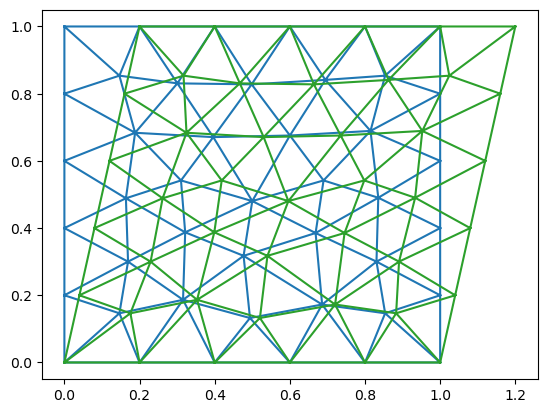

In [12]:
triplot(ref_node_coords[:,0], ref_node_coords[:,1], triangles=S.S[2])
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S.S[2])

In [13]:
print(ela.obj_linear_elasticity_energy(curr_node_coords, f, gamma, boundary_values, ext_forces_coeffs))
print(ela.obj_linear_elasticity_energy(true_curr_node_coords, f, gamma, boundary_values, ext_forces_coeffs))

[[ 0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.29901942e-10  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.30385486e-10  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.75819197e-10  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.80447346e-10  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+

In [16]:
#print(true_curr_node_coords)
#print(curr_node_coords)
print(true_curr_node_coords)
print(curr_node_coords)
print(np.allclose(true_curr_node_coords, curr_node_coords, atol=1e-5))

[[0.         0.         0.        ]
 [1.         0.         0.        ]
 [1.2        1.         0.        ]
 [0.2        1.         0.        ]
 [0.2        0.         0.        ]
 [0.4        0.         0.        ]
 [0.6        0.         0.        ]
 [0.8        0.         0.        ]
 [1.04       0.2        0.        ]
 [1.08       0.4        0.        ]
 [1.12       0.6        0.        ]
 [1.16       0.8        0.        ]
 [1.         1.         0.        ]
 [0.8        1.         0.        ]
 [0.6        1.         0.        ]
 [0.4        1.         0.        ]
 [0.16       0.8        0.        ]
 [0.12       0.6        0.        ]
 [0.08       0.4        0.        ]
 [0.04       0.2        0.        ]
 [0.26143963 0.48866509 0.        ]
 [0.93340959 0.49029969 0.        ]
 [0.52039366 0.13237604 0.        ]
 [0.66391313 0.82773866 0.        ]
 [0.46688877 0.83070291 0.        ]
 [0.53030677 0.67073445 0.        ]
 [0.73530537 0.67551889 0.        ]
 [0.59607695 0.48038476 0.  